In [1]:
import matplotlib.pyplot as plt
import qutip as qt
import numpy as np

In [ ]:
SPIN = 1    # Ions spin
n = int(2 * SPIN + 1)

# System parameters
N_IONS = 2
J0 = 1.3094570021973102e3 * 2 * np.pi
V01 = 200 * 2 * np.pi
V02 = 150 * 2 * np.pi
alpha = 1.0

# Spin operators definition
_Sp = qt.spin_Jp(SPIN)
_Sm = qt.spin_Jm(SPIN)
_Sx = qt.spin_Jx(SPIN)
_Sy = qt.spin_Jy(SPIN)
_Sz = qt.spin_Jz(SPIN)
Sp = [qt.tensor([qt.qeye(n)] * i + [_Sp] + [qt.qeye(n)] * (N_IONS - i - 1)) for i in range(N_IONS)]
Sm = [qt.tensor([qt.qeye(n)] * i + [_Sm] + [qt.qeye(n)] * (N_IONS - i - 1)) for i in range(N_IONS)]
Sz = [qt.tensor([qt.qeye(n)] * i + [_Sz] + [qt.qeye(n)] * (N_IONS - i - 1)) for i in range(N_IONS)]


def D(t):
    return 5e3 * 2 * np.pi * np.exp(-t/0.167e-3)

def H_t(t):
    H = qt.qzero(Sm[0].dims[0])
    for i in range(N_IONS):
        H += D(t) * Sz[i] ** 2
        for j in range(i + 1, N_IONS):
            H += (Sp[i] * Sm[j] + Sm[i] * Sp[j]) * (-J0 * 0.25 / (np.abs(i - j) ** alpha))
    H += V01 * Sz[1] - V02 * Sz[1] ** 2
    return H

# Basis states
state = {
    '00': qt.tensor([qt.basis(n, 1), qt.basis(n, 1)]),
    '0+': qt.tensor([qt.basis(n, 1), qt.basis(n, 0)]),
    '0-': qt.tensor([qt.basis(n, 1), qt.basis(n, 2)]),
    '+0': qt.tensor([qt.basis(n, 0), qt.basis(n, 1)]),
    '-0': qt.tensor([qt.basis(n, 2), qt.basis(n, 1)]),
    '++': qt.tensor([qt.basis(n, 0), qt.basis(n, 0)]),
    '--': qt.tensor([qt.basis(n, 2), qt.basis(n, 2)]),
    '+-': qt.tensor([qt.basis(n, 0), qt.basis(n, 2)]),
    '-+': qt.tensor([qt.basis(n, 2), qt.basis(n, 0)]),
}

psi_0 = qt.tensor([qt.basis(n, 1)] * N_IONS)
t = np.linspace(0, 1e-3, 1000)

ground = state['00']/np.sqrt(2) + 0.5*(state['+-'] + state['-+'])
proj = ground.proj()

proj_0p_0m = (state['0+'] + state['0-']) * (state['0+'] + state['0-']).dag() / 2
proj_m0_p0 = (state['-0'] + state['+0']) * (state['-0'] + state['+0']).dag() / 2
proj_pp_pm_mp_mm = (state['++'] + state['+-'] + state['-+'] + state['--']) * (state['++'] + state['+-'] + state['-+'] + state['--']).dag() / 2

proj_mm = (state['--']) * (state['--']).dag()
proj_m0_mp = (state['-0'] + state['-+']) * (state['-0'] + state['-+']).dag()
proj_0m_pm = (state['0-'] + state['+-']) * (state['0-'] + state['+-']).dag()
proj_00_0p_p0_pp = (state['00'] + state['0+'] + state['+0'] + state['++']) * (state['00'] + state['0+'] + state['+0'] + state['++']).dag()

sol = qt.mesolve(H_t, psi_0, t, None, [proj, state['00'].proj(), proj_0p_0m, proj_m0_p0, proj_pp_pm_mp_mm])
sol_m = qt.mesolve(H_t, psi_0, t, None, [proj, proj_mm, proj_m0_mp, proj_0m_pm, proj_00_0p_p0_pp])

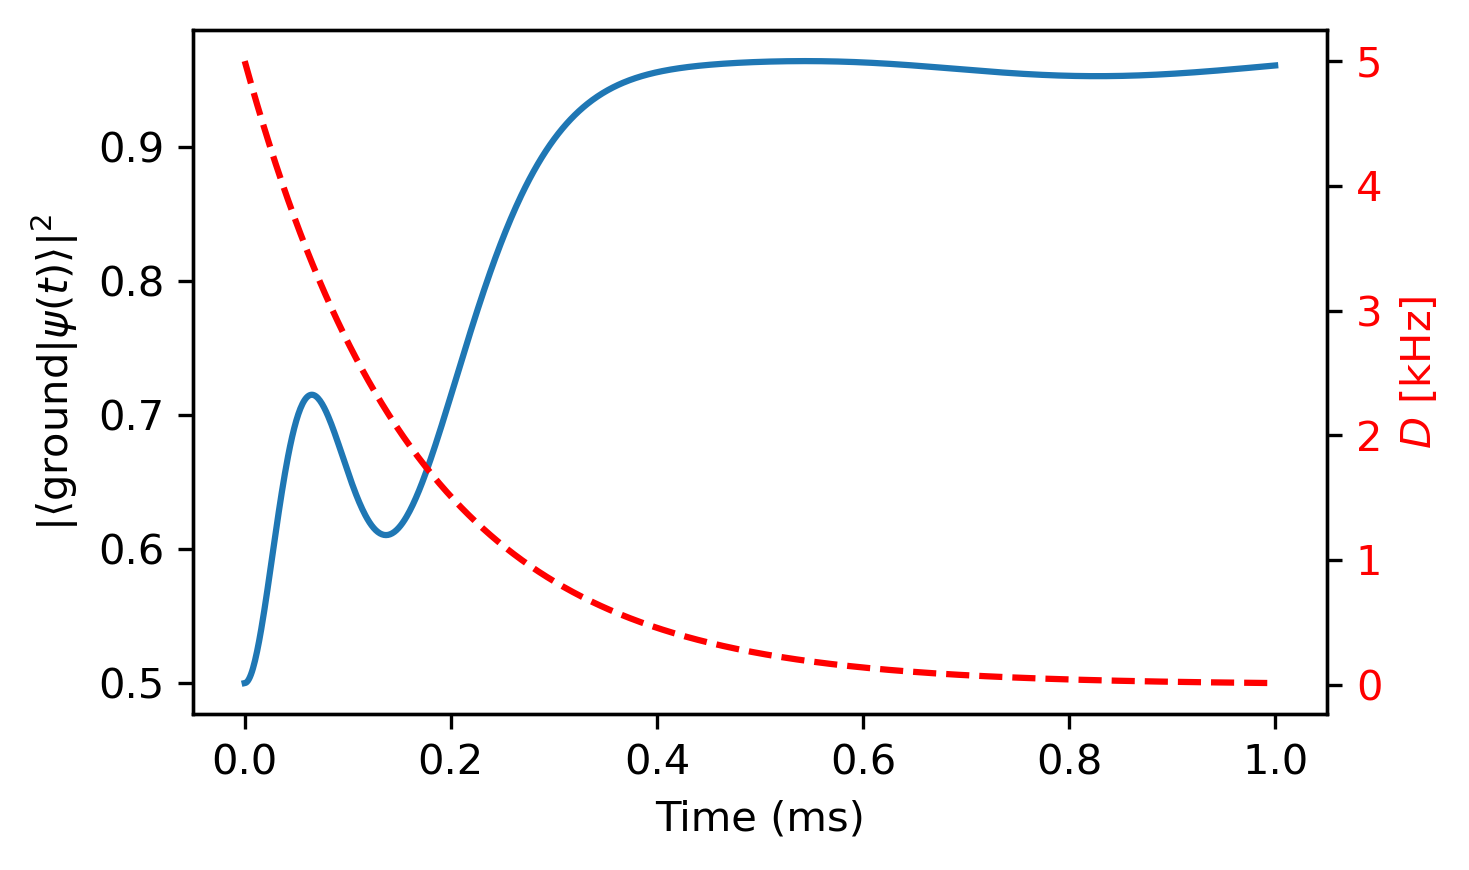

In [5]:
fig, ax1 = plt.subplots(figsize=(5, 3), dpi=300)
ax1.plot(t*1e3, sol.expect[0], label='$|\\langle \\text{ground} | \\psi(t) \\rangle|^2$', color='C0')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('$|\\langle \\text{ground} | \\psi(t) \\rangle|^2$')

ax2 = ax1.twinx()
ax2.plot(t*1e3, D(t)/(2*np.pi*1000), 'r--', label='C1')
ax2.set_ylabel('$D$ [kHz]', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.tight_layout()
plt.show()